<a href="https://colab.research.google.com/github/LuigiElo/DL-PINNs/blob/main/PINN_Laplace2D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets
!pip install transformers
!pip install deepxde
!pip install paddle
!pip install git+https://github.com/dr-aheydari/SoftAdapt.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.2/166.2 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 579.0/579.0 kB 8.2 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


Compiling model...
Building feed-forward neural network...
'build' took 0.088813 s

'compile' took 1.220342 s

Training model...

Step      Train loss                        Test loss                         Test metric   
0         [2.42e-03, 6.77e+00, 2.19e+01]    [2.21e-03, 6.77e+00, 2.19e+01]    [1.40e+01]    
1000      [2.52e-05, 4.49e-05, 2.79e-05]    [2.53e-05, 4.49e-05, 2.79e-05]    [2.08e+00]    
2000      [8.27e-06, 3.39e-05, 1.16e-05]    [6.98e-06, 3.39e-05, 1.16e-05]    [2.84e+00]    
3000      [4.48e-06, 2.49e-05, 4.50e-06]    [3.05e-06, 2.49e-05, 4.50e-06]    [3.17e+00]    
4000      [3.19e-06, 1.55e-05, 2.16e-06]    [2.21e-06, 1.55e-05, 2.16e-06]    [2.92e+00]    
5000      [1.65e-06, 7.04e-06, 9.91e-07]    [1.12e-06, 7.04e-06, 9.91e-07]    [2.39e+00]    

Best model at step 5000:
  train loss: 9.68e-06
  test loss: 9.15e-06
  test metric: [2.39e+00]

'train' took 25.189212 s

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Sav

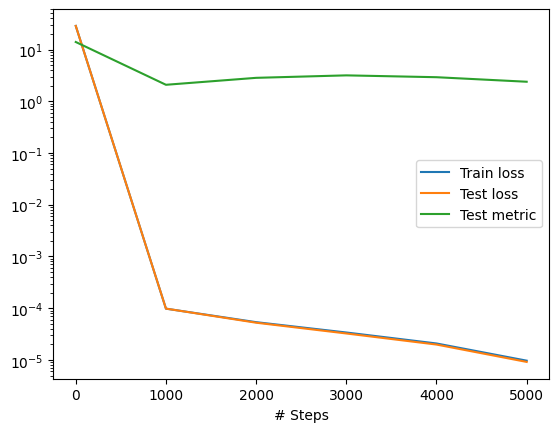

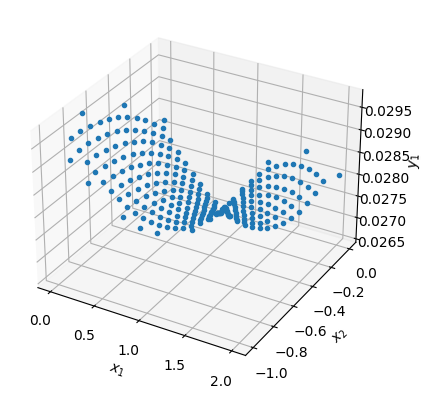

Saving training data to train.dat ...
Saving test data to test.dat ...


In [10]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, paddle"""
import deepxde as dde
import numpy as np
import pandas as pd
def dudx(x, u):
  return dde.grad.jacobian(u, x, i=0)

# General parameters
L = 2.0 # wave/x length
h = 1 # depth
T = 1 # period
H = 0.05 # surface wave amplitude (I chose it arbitrarliy. Check p. 68 HRC)
c = L/T # wave propagation velocity (p. 70 HCR)
k = 2*np.pi/L # wave nr.
w = 2*np.pi/T

t = 0 # we are looking at a snapshot, so t is constant

precision_train = 10
precision_test = 30
hard_constraint = False
weights = 1  # if hard_constraint == False
iterations = 5000
parameters = [1e-4, 3, 150, "tanh"]

# Define sine function
if dde.backend.backend_name == "pytorch":
    sin = dde.backend.pytorch.sin
elif dde.backend.backend_name == "paddle":
    sin = dde.backend.paddle.sin
else:
    from deepxde.backend import tf

    sin = tf.sin

learning_rate, num_dense_layers, num_dense_nodes, activation = parameters


def pde(x, y):
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    dy_yy = dde.grad.hessian(y, x, i=1, j=1)

    return dy_xx + dy_yy


# Analytical solution (HRC p. 75)
def func(x):
    return -H*c/2 * np.cosh(k*(x[:, 1:2]+h))/np.sinh(k*h) * np.sin(w*t - k*x[:, 0:1])


def transform(x, y):
    res = x[:, 0:1] * (1 - x[:, 0:1]) * x[:, 1:2] * (1 - x[:, 1:2])
    return res * y


def boundary(_, on_boundary):
    return on_boundary

def boundary_bottom(x, on_boundary):
    return  on_boundary and dde.utils.isclose(x[1],-h)


def boundary_left(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 0)

def boundary_right(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], L)

# Defining geometry
#geom = dde.geometry.Rectangle([0, 0], [1, 1])
geom = dde.geometry.Rectangle([0, -h], [L, 0])

# Defining random training and test collocation points
wave_len = L

hx_train = wave_len / precision_train
nx_train = int(1 / hx_train)

hx_test = wave_len / precision_test
nx_test = int(1 / hx_test)

# Transformation is applied if boundary constraints are applied in hard fashion
if hard_constraint == True:
    bc = []
else:
    bc1=dde.icbc.NeumannBC(geom, lambda x: 0, boundary_bottom)
    bc2=dde.icbc.NeumannBC(geom, lambda x: 0, boundary_right) # doubt: ask later about velocity in the sides
    bc3=dde.icbc.NeumannBC(geom, lambda x: 0, boundary_left) # doubt: ask later about velocity in the sides
    #bc2= dde.icbc.DirichletBC(geom, lambda x: 0, boundary_left, component=0)
    #bc3=dde.icbc.DirichletBC(geom, lambda x: 0, boundary_right, component=0)
    bc4=dde.icbc.PeriodicBC(geom,0,boundary_right)
    bc = [bc1,bc4]


# Generate training and testing points
data = dde.data.PDE(
    geom,
    pde,
    bc,
    num_domain=nx_train ** 2,
    num_boundary=4 * nx_train,
    solution=func,
    num_test=nx_test ** 2,
)

# Choose network
net = dde.nn.FNN(
    [2] + [num_dense_nodes] * num_dense_layers + [1], activation, "Glorot uniform"
)

# Apply transform to enforce boundary conditions
if hard_constraint == True:
    net.apply_output_transform(transform)

# Build model
model = dde.Model(data, net)

if hard_constraint == True:
    model.compile("adam", lr=learning_rate, metrics=["l2 relative error"])
else:
    loss_weights = [weights, 100,100]
    model.compile(
        "adam",
        lr=learning_rate,
        metrics=["l2 relative error"],
        loss_weights=loss_weights,
    )



losshistory, train_state = model.train(iterations=iterations)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)
dde.utils.external.save_best_state(train_state,"train.dat","test.dat")
